### Test 2
## Point cloud generation from multiple views of CAD objects
In this notebook we attempt to improve point-cloud reconstruction with 3d-consistent multiple views from the [Scene Representation Networks Cars Dataset](https://github.com/vsitzmann/scene-representation-networks).Each sample consists in an object with related views, rotation matrix, translation vector and calibration matrix.

In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading rendered views from SRN Cars

In [3]:
import os, random
base_path = os.path.join("..", "..", "distributed-3d-diffusion-pytorch", "data", "SRN", "cars_train")
samples = os.listdir(base_path)

# Get one random sample from SRN cars dataset
num_views = 4
idx = random.randint(1, len(samples))
random_sample_path = os.path.join(base_path, samples[idx], "rgb")

# Get 4 random views
for root, dirs, files in os.walk(random_sample_path):
    random_views_filenames = random.choices(list(set(files)), k=num_views)
    
# Convert to PILLOW Images
images = []
for f in random_views_filenames: images.append(Image.open(os.path.join(random_sample_path, f)))

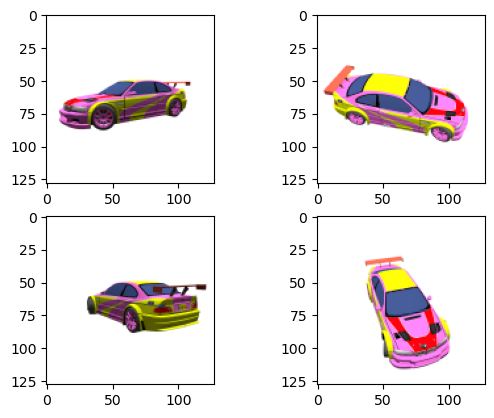

In [4]:
cols = 2
rows = (num_views // cols)
f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(np.asarray(images[i]))

### Point cloud generation with POINT-E

In [5]:
from mv_point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from mv_point_e.diffusion.sampler import PointCloudSampler
from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config
from mv_point_e.util.plotting import plot_point_cloud

Strange thing: even though the num. tokens is changed, the transformer still loads the pre-trained weights and it also accepts inputs with a different number of tokens.

In [6]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

# Instantiating POINT-E with 4 views
MODEL_CONFIGS[base_name]["n_views"] = num_views
MODEL_CONFIGS['upsample']["n_views"] = num_views

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [7]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [9]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=images))):
    samples = x

0it [00:00, ?it/s]

In [10]:
samples.shape

torch.Size([1, 6, 4096])

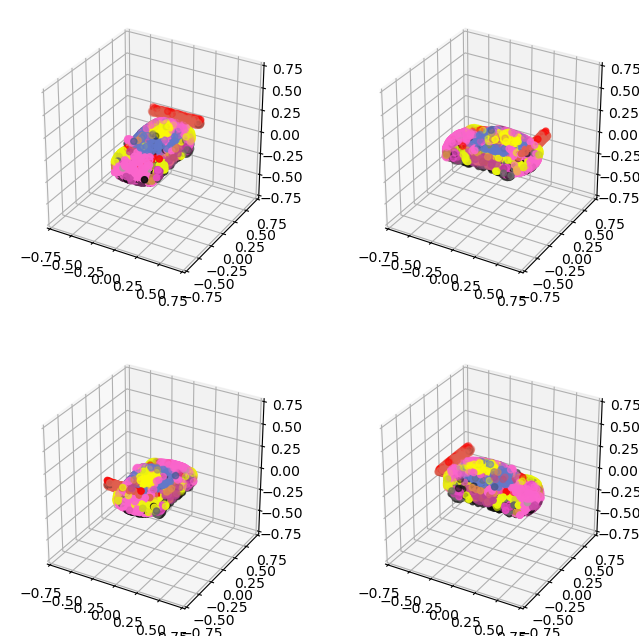

In [11]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

### Point cloud to mesh with SDF

In [12]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config
from mv_point_e.util.pc_to_mesh import marching_cubes_mesh
from mv_point_e.util.plotting import plot_point_cloud
from mv_point_e.util.point_cloud import PointCloud

In [13]:
# Signed distance field model
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [18]:
import skimage.measure
skimage.measure.label

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=256, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/4096 [00:00<?, ?it/s]

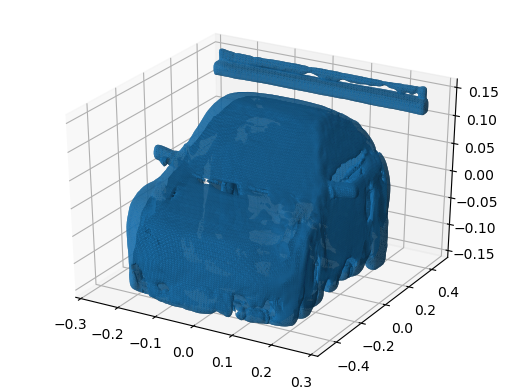

In [19]:
# Write the mesh to a PLY file to import into some other program.
# with open('mesh.ply', 'wb') as f:
#    mesh.write_ply(f)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:,1], triangles=mesh.faces, Z=mesh.verts[:,2]) 
plt.show()